<a href="https://colab.research.google.com/github/tobiaskaczka/flu-h1n1-predictions/blob/main/flu_h1n1_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train = pd.read_csv("training_set_features.csv")
test = pd.read_csv("test_set_features.csv")
labels = pd.read_csv("training_set_labels.csv")

In [ ]:
#At a glance, health_insurance and the two employment columns have too many nulls to be relevant
missing = train.isnull().sum().sort_values(ascending=False)
percentMissing = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missingWithPercent = pd.concat([missing, percentMissing*100], axis=1)
missingWithPercent.head(40)

,0,1
employment_occupation,13470,50.436215
employment_industry,13330,49.912008
health_insurance,12274,45.957989
income_poverty,4423,16.561201
doctor_recc_h1n1,2160,8.087767
doctor_recc_seasonal,2160,8.087767
rent_or_own,2042,7.645936
employment_status,1463,5.477965
marital_status,1408,5.272026
education,1407,5.268282


In [ ]:
train.drop(['health_insurance','employment_industry','employment_occupation'], axis=1, inplace=True)

In [ ]:
trainLabels = pd.merge(train, labels)

sns.set_theme(font_scale=1)
plt.figure(figsize=(200,200))
sns.heatmap(trainLabels.corr(), annot=True)
plt.show()

#based on correlations, the following features are best: ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'health_worker', 'chronic_med_condition', 'h1n1_concern', 'h1n1_knowledge']

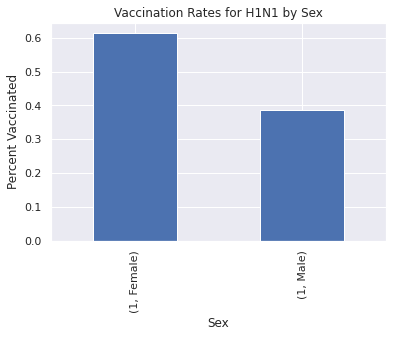

In [ ]:
trainLabels[['h1n1_vaccine', 'sex']].loc[trainLabels[['h1n1_vaccine', 'sex']].h1n1_vaccine==1].value_counts(normalize=True).plot.bar(title = "Vaccination Rates for H1N1 by Sex",
                                                                                                                                     ylabel="Percent Vaccinated",
                                                                                                                                     xlabel="Sex"
)

In [ ]:
trainLabels.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


In [ ]:
#grouping into categorical and numerical
#.corr() gave us numerical, but must figure out categorical seperately

cols = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands','behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective','opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'sex', 'rent_or_own', 'household_children']

categorical = train[cols].select_dtypes(include=['object']).columns.tolist()
numerical = train[cols].select_dtypes(exclude=['object']).columns.tolist()

print(categorical) 
print(numerical)

['sex', 'rent_or_own']
['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'household_children']


In [ ]:
imp_constant = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(handle_unknown='ignore')

In [ ]:
imp_ohe = make_pipeline(imp_constant, ohe)
vect = CountVectorizer()
imp = SimpleImputer()

In [ ]:
ct = make_column_transformer(
    (imp_ohe, categorical), #group by categories and fill missing values
    (imp, numerical), #handles missing values, non categorical
    remainder='passthrough'
)

In [ ]:
clfxg = xgboost.XGBClassifier()

In [ ]:
pipe = make_pipeline(ct, clfxg)
pipe.fit(train[cols], labels.h1n1_vaccine)
pred = pipe.predict(test)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, train[cols], labels.h1n1_vaccine, cv=10, scoring='accuracy').mean()
#83.6

0.8367095744695767

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, train[cols], labels.seasonal_vaccine, cv=10, scoring='accuracy').mean()
#77.2

0.7655669789401212